In this Notebook I will show how to solve EMNIST dataset with Multilayer Perceptron.

### Import

In [1]:
!pip install -q keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.datasets import mnist
from keras.callbacks import EarlyStopping

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

!pip install tqdm
from tqdm import tqdm
from urllib.request import urlretrieve

import os
import gzip
import random as rn
import numpy as np

# Randomness control
os.environ['PYTHONHASHSEED'] = '0'
RANDOM_SEED = 3939
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
                              inter_op_parallelism_threads=1)

tf.set_random_seed(RANDOM_SEED)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
keras.backend.set_session(sess)

Using TensorFlow backend.


### Constants

In [0]:
DATA_URLS = [
    "https://www.dropbox.com/s/2ccuz4wntcfm2nm/emnist-letters-train-labels-idx1-ubyte.gz?dl=1",
    "https://www.dropbox.com/s/jwv9jra58gpe1vu/emnist-letters-train-images-idx3-ubyte.gz?dl=1",
    "https://www.dropbox.com/s/e3q7hycso3zm4a8/emnist-letters-test-labels-idx1-ubyte.gz?dl=1",
    "https://www.dropbox.com/s/255drxbkmqj1ab1/emnist-letters-test-images-idx3-ubyte.gz?dl=1"
]

FILE_NAMES = [
    "emnist-letters-train-labels-idx1-ubyte.gz",
    "emnist-letters-train-images-idx3-ubyte.gz",
    "emnist-letters-test-labels-idx1-ubyte.gz",
    "emnist-letters-test-images-idx3-ubyte.gz"
]

IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 26
TRAIN_IMAGE_NUMBER = 124800
TEST_IMAGE_NUMBER = 20800

### Loading Data

EMNIST data is downloaded from https://www.nist.gov/itl/iad/image-group/emnist-dataset and uploaded to my Dropbox so it can be easily downloaded from code.

In [0]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

for url, filename in zip(DATA_URLS, FILE_NAMES):
    if not os.path.isfile(filename):
        with DLProgress(unit="B", unit_scale=True, miniters=1, desc="EMNIST:" + filename) as pbar:
            urlretrieve(url, filename, pbar.hook)

In [0]:
def extract_data(file_path, num_images):
    with gzip.open(file_path) as bstream:
        bstream.read(16)
        buffer = bstream.read(IMAGE_WIDTH * IMAGE_HEIGHT * num_images)
        data = np.frombuffer(buffer, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, IMAGE_WIDTH, IMAGE_HEIGHT, 1)
        return data

In [0]:
def extract_labels(file_path, num_images):
    with gzip.open(file_path) as bstream:
        bstream.read(8)
        buffer = bstream.read(1 * num_images)
        labels = np.frombuffer(buffer, dtype=np.uint8).astype(np.int64)
    return labels

In [0]:
X_train = extract_data("emnist-letters-train-images-idx3-ubyte.gz", TRAIN_IMAGE_NUMBER)
y_train = extract_labels("emnist-letters-train-labels-idx1-ubyte.gz", TRAIN_IMAGE_NUMBER)
X_test = extract_data("emnist-letters-test-images-idx3-ubyte.gz", TEST_IMAGE_NUMBER)
y_test = extract_labels("emnist-letters-test-labels-idx1-ubyte.gz", TEST_IMAGE_NUMBER)

### Data Visualisation

In [0]:
def show_letters(X_train, y_train, rows_num=6):    
    figure, axes = plt.subplots(nrows=rows_num, ncols=6, sharex=True, sharey=True, figsize=(20, rows_num * 2))
    
    for row_index in range(rows_num):
        ax_row = axes[row_index]
        images = X_train[(row_index*8):(row_index+1)*8]
        labels = y_train[(row_index*8):(row_index+1)*8]
        
        for ax, img, label in zip(ax_row, images, labels):
            img_reshaped = img.reshape(IMAGE_WIDTH, IMAGE_HEIGHT)
            ax.imshow(img_reshaped, cmap='gray_r')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title("Label - {}".format(label))

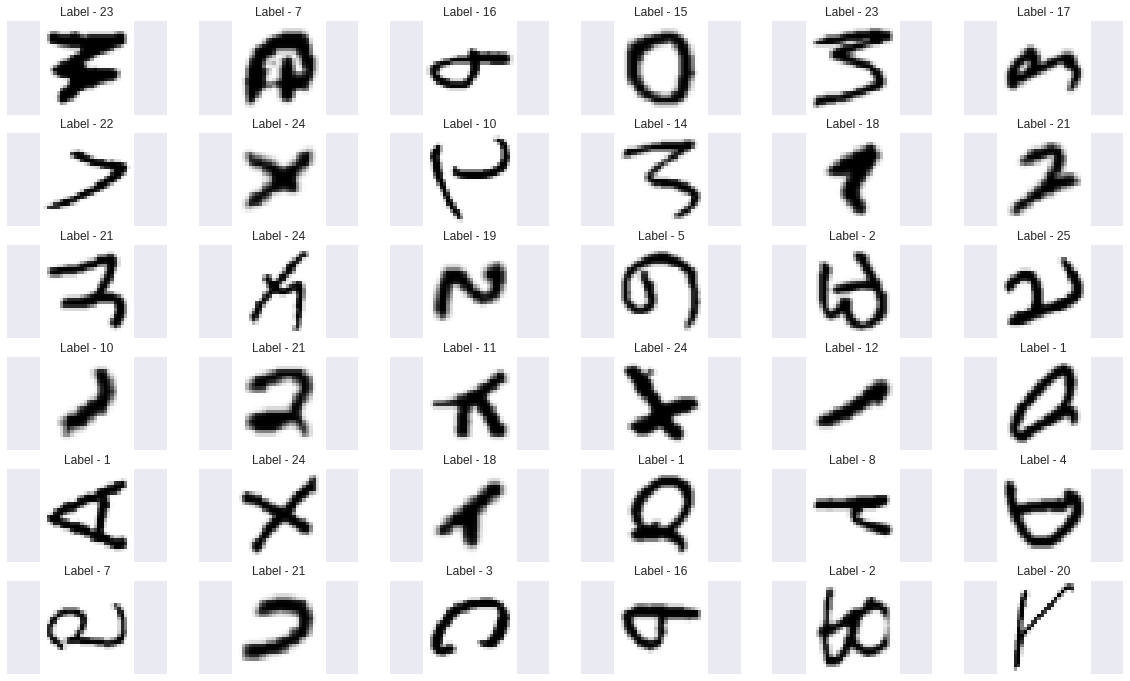

In [8]:
show_letters(X_train, y_train)

### Data Preprocessing

Unwrapping image matrices into vectors

In [9]:
print("Training data - before unwrapping: ")
print(" - shape: {}".format(X_train.shape))
print(" - label: {}".format(y_train.shape))
print("Test data - before unwrapping: ")
print(" - shape: {}".format(X_test.shape))
print(" - label: {}".format(y_test.shape))

X_train = X_train.reshape(TRAIN_IMAGE_NUMBER, IMAGE_WIDTH * IMAGE_HEIGHT)
X_test = X_test.reshape(TEST_IMAGE_NUMBER, IMAGE_WIDTH * IMAGE_HEIGHT)

print("\nTraining data - after unwrapping: ")
print(" - shape: {}".format(X_train.shape))
print(" - label: {}".format(y_train.shape))
print("Test data - after unwrapping: ")
print(" - shape: {}".format(X_test.shape))
print(" - label: {}".format(y_test.shape))

Training data - before unwrapping: 
 - shape: (124800, 28, 28, 1)
 - label: (124800,)
Test data - before unwrapping: 
 - shape: (20800, 28, 28, 1)
 - label: (20800,)

Training data - after unwrapping: 
 - shape: (124800, 784)
 - label: (124800,)
Test data - after unwrapping: 
 - shape: (20800, 784)
 - label: (20800,)


Normalization

In [10]:
print("Training data - before normalization: ")
print(" - min: {}".format(X_train.min()))
print(" - max: {}".format(X_train.max()))
print("Test data - after normalization: ")
print(" - min: {}".format(X_test.min()))
print(" - max: {}".format(X_test.max()))

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print("\nTraining data - after normalization: ")
print(" - min: {}".format(X_train.min()))
print(" - max: {}".format(X_train.max()))
print("Test data - after normalization: ")
print(" - min: {}".format(X_test.min()))
print(" - max: {}".format(X_test.max()))

Training data - before normalization: 
 - min: 0.0
 - max: 255.0
Test data - after normalization: 
 - min: 0.0
 - max: 255.0

Training data - after normalization: 
 - min: 0.0
 - max: 1.0
Test data - after normalization: 
 - min: 0.0
 - max: 1.0


Fixing indices class numering

In [11]:
print("Labels before fixing has values from <1,26>:")
print("y_train values: {}".format(set(y_train)))
print("y_test values: {}".format(set(y_test)))

y_train = y_train - 1 
y_test = y_test - 1

print("Labels after fixing has values from <0,25>:")
print("y_train values: {}".format(set(y_train)))
print("y_test values: {}".format(set(y_test)))

Labels before fixing has values from <1,26>:
y_train values: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
y_test values: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
Labels after fixing has values from <0,25>:
y_train values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
y_test values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}


One-Hot Encoding

In [12]:
print("Train data labels - before OHE: ")
print(" - example: {}\n".format(y_train[:10]))
print("Test data labels - before OHE: ")
print(" - example: {}\n".format(y_test[:10]))


y_train = keras.utils.to_categorical(y_train, NUM_LABELS)
y_test = keras.utils.to_categorical(y_test, NUM_LABELS)

print("\nTrain data labels - after OHE: ")
print(" - example: {}\n".format(y_train[:10]))
print("Test data labels - after OHE: ")
print(" - example: {}\n".format(y_test[:10]))

Train data labels - before OHE: 
 - example: [22  6 15 14 22 16 12 10 21 23]

Test data labels - before OHE: 
 - example: [0 0 0 0 0 0 0 0 0 0]


Train data labels - after OHE: 
 - example: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

### Train/Validation data split

In [13]:
split_ratio = 0.8
split_index = int(X_train.shape[0] * split_ratio)

X_train_input, y_train_input = X_train[:split_index], y_train[:split_index]
X_val_input, y_val_input = X_train[split_index:], y_train[split_index:]

print("X_train_input shape: {}".format(X_train_input.shape))
print("y_train_input shape: {}".format(y_train_input.shape))
print("X_val_input shape: {}".format(X_val_input.shape))
print("y_val_input shape: {}".format(y_val_input.shape))

X_train_input shape: (99840, 784)
y_train_input shape: (99840, 26)
X_val_input shape: (24960, 784)
y_val_input shape: (24960, 26)


### Model

Creation

In [14]:
model = Sequential()
model.add(Dense(1024, 
                input_shape=(IMAGE_WIDTH * IMAGE_HEIGHT,), 
                use_bias=False,
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.4))
model.add(Dense(512,
                use_bias=False,
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.3))
model.add(Dense(NUM_LABELS, 
                activation="softmax",
                kernel_initializer=glorot_uniform(seed=RANDOM_SEED)))


model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(0.005), 
              metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              802816    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524288    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
__________

Training

In [16]:
history = model.fit(X_train_input, y_train_input,
                    batch_size=64,
                    epochs=30,
                    verbose=2,
                    validation_data=(X_val_input, y_val_input))

Train on 99840 samples, validate on 24960 samples
Epoch 1/30
 - 14s - loss: 0.7161 - acc: 0.7781 - val_loss: 0.3883 - val_acc: 0.8724
Epoch 2/30
 - 14s - loss: 0.4725 - acc: 0.8485 - val_loss: 0.3258 - val_acc: 0.8958
Epoch 3/30
 - 14s - loss: 0.4137 - acc: 0.8658 - val_loss: 0.2981 - val_acc: 0.9031
Epoch 4/30
 - 14s - loss: 0.3752 - acc: 0.8765 - val_loss: 0.2841 - val_acc: 0.9077
Epoch 5/30
 - 14s - loss: 0.3527 - acc: 0.8826 - val_loss: 0.2699 - val_acc: 0.9128
Epoch 6/30
 - 14s - loss: 0.3312 - acc: 0.8894 - val_loss: 0.2636 - val_acc: 0.9164
Epoch 7/30
 - 14s - loss: 0.3159 - acc: 0.8954 - val_loss: 0.2594 - val_acc: 0.9127
Epoch 8/30
 - 14s - loss: 0.3011 - acc: 0.8985 - val_loss: 0.2477 - val_acc: 0.9204
Epoch 9/30
 - 14s - loss: 0.2894 - acc: 0.9019 - val_loss: 0.2471 - val_acc: 0.9195
Epoch 10/30
 - 14s - loss: 0.2790 - acc: 0.9047 - val_loss: 0.2400 - val_acc: 0.9256
Epoch 11/30
 - 14s - loss: 0.2696 - acc: 0.9082 - val_loss: 0.2428 - val_acc: 0.9225
Epoch 12/30
 - 14s - los

Evaluation

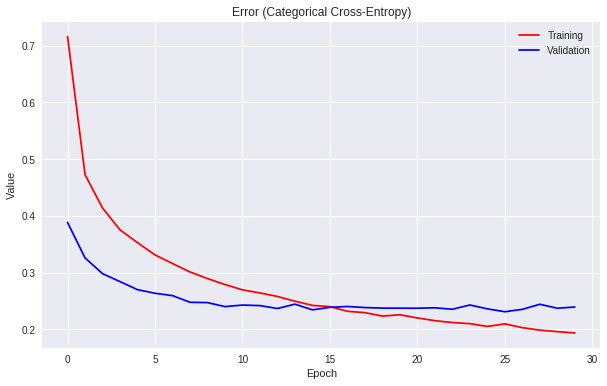

In [18]:
f, ax = plt.subplots()
f.set_size_inches(10, 6)
    
ax.plot(history.history["loss"], c="r")
ax.plot(history.history["val_loss"], c="b")
ax.set_title("Error (Categorical Cross-Entropy)")
ax.set_ylabel("Value")
ax.set_xlabel("Epoch")
ax.legend(["Training", "Validation"], loc="best");

In [19]:
train_score = model.evaluate(X_train_input, y_train_input, verbose=0)
val_score = model.evaluate(X_val_input, y_val_input, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)
  
train_score, train_accuracy = train_score
print("Train data results:")
print(" - error: {}".format(train_score))
print(" - acc: {}".format(train_accuracy))

val_score, val_accuracy = val_score
print("Validation data results:")
print(" - error: {}".format(val_score))
print(" - acc: {}".format(val_accuracy))

test_score, test_accuracy = test_score
print("Test data results:")
print(" - error: {}".format(test_score))
print(" - acc: {}".format(test_accuracy))

Train data results:
 - error: 0.08366496303157571
 - acc: 0.9678185096153846
Validation data results:
 - error: 0.23936254560159376
 - acc: 0.9286858974358975
Test data results:
 - error: 0.24809971435076128
 - acc: 0.9275961538461538
